In [126]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import scipy.stats as st
import os
import numpy as np
import random
from scipy.stats import linregress
from scipy.stats import pearsonr
import hvplot.pandas
import requests

In [127]:
movie_df = pd.read_csv('movies_awards.csv')
movie_df.shape

(5579, 21)

In [128]:
# Identify duplicate movie titles
duplicate_titles = movie_df[movie_df.duplicated(subset='Movie_Title', keep=False)]
title_counts = duplicate_titles['Movie_Title'].value_counts()
print(title_counts)

Movie_Title
Little Women            6
West Side Story         4
The Great Gatsby        4
Robin Hood              3
A Star Is Born          3
                       ..
Hummingbird             2
Red Dawn                2
The Three Musketeers    2
Godzilla                2
Black Sheep             2
Name: count, Length: 113, dtype: int64


In [129]:
# Drop Duplicates
df_unique = movie_df.drop_duplicates(subset='Movie_Title', keep='first')
df_unique.shape


(5453, 21)

In [130]:
filter_criteria = (
    (df_unique['Metascore'].notna()) &
    (df_unique['Box Office'].notna()) &
    (df_unique['Oscar Nomination'].notna()) & 
    #(df_unique['Rotten Tomatoes Rating'].notna()) & 
    (df_unique['Metascore'] != 'Rating not found') &  
    #(df_unique['Rotten Tomatoes Rating'] != 'Rating not found') &  
    (df_unique['Box Office'] != 'Box Office not found')
)
clean_movie_df = df_unique[filter_criteria]
clean_movie_df.shape


(71, 21)

In [131]:
clean_movie_df2 = clean_movie_df.copy()
clean_movie_df3 = clean_movie_df.copy()


In [132]:
#clean_movie_df2['Rotten Tomatoes Rating'] = pd.to_numeric(clean_movie_df2['Rotten Tomatoes Rating'], errors='coerce')
clean_movie_df2['IMDb Rating'] = pd.to_numeric(clean_movie_df2['IMDb Rating'], errors='coerce')
clean_movie_df2['Metascore'] = pd.to_numeric(clean_movie_df2['Metascore'], errors='coerce')
print(clean_movie_df2.dtypes)

Movie_Title                object
Year                        int64
Director                   object
Actors                     object
Rating                    float64
Runtime(Mins)               int64
Censor                     object
Total_Gross                object
main_genre                 object
side_genre                 object
Movie Rated                object
Language                   object
Rotten Tomatoes Rating     object
IMDb Rating               float64
Metascore                   int64
Box Office                 object
imdbID                     object
Oscar Award               float64
Oscar Nomination          float64
Award Wins                float64
Award Nominations         float64
dtype: object


In [133]:
def convert_to_float(x):
    if isinstance(x, str):  # Check if the input is a string
        if '/' in x:  # Handling fractions
            numerator, denominator = x.split('/')
            return float(numerator) / float(denominator)
        elif '%' in x:  # Handling percentages
            return float(x.rstrip('%')) / 100  # Remove the '%' and convert to decimal
        else:
            return float(x)  # Convert directly if no special characters
    return x  # Return as is if it's already a numeric type

In [134]:
clean_movie_df2['Rotten Tomatoes Rating'] = clean_movie_df2['Rotten Tomatoes Rating'].apply(convert_to_float)
print(clean_movie_df2.dtypes)


Movie_Title                object
Year                        int64
Director                   object
Actors                     object
Rating                    float64
Runtime(Mins)               int64
Censor                     object
Total_Gross                object
main_genre                 object
side_genre                 object
Movie Rated                object
Language                   object
Rotten Tomatoes Rating    float64
IMDb Rating               float64
Metascore                   int64
Box Office                 object
imdbID                     object
Oscar Award               float64
Oscar Nomination          float64
Award Wins                float64
Award Nominations         float64
dtype: object


In [135]:
# Convert 'Box Office' to numeric after removing $ and commas
clean_movie_df2['Box Office'] = clean_movie_df2['Box Office'].replace('[\$,]', '', regex=True).astype(int)

# Convert millions to a more readable format
clean_movie_df2['Box Office (in M)'] = (clean_movie_df2['Box Office'] / 1e6).round(1).astype(str) + 'M'

clean_movie_df2.head(5)

,Movie_Title,Year,Director,Actors,Rating,Runtime(Mins),Censor,Total_Gross,main_genre,side_genre,...,Rotten Tomatoes Rating,IMDb Rating,Metascore,Box Office,imdbID,Oscar Award,Oscar Nomination,Award Wins,Award Nominations,Box Office (in M)
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,152,UA,$534.86M,Action,"Crime, Drama",...,0.94,9.0,84,534987076,tt0468569,2.0,8.0,163.0,164.0,535.0M
2,The Lord of the Rings: The Return of the King,2003,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",9.0,201,U,$377.85M,Action,"Adventure, Drama",...,0.94,9.0,94,379427292,tt0167260,11.0,11.0,215.0,124.0,379.4M
3,Inception,2010,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.8,148,UA,$292.58M,Action,"Adventure, Sci-Fi",...,0.87,8.8,74,292587330,tt1375666,4.0,8.0,159.0,220.0,292.6M
4,The Lord of the Rings: The Two Towers,2002,Peter Jackson,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...",8.8,179,UA,$342.55M,Action,"Adventure, Drama",...,0.95,8.8,87,342952511,tt0167261,2.0,6.0,132.0,138.0,343.0M
5,The Lord of the Rings: The Fellowship of the Ring,2001,Peter Jackson,"Elijah Wood, Ian McKellen, Orlando Bloom, Sean...",8.8,178,U,$315.54M,Action,"Adventure, Drama",...,0.91,8.9,92,316115420,tt0120737,4.0,13.0,125.0,127.0,316.1M


In [136]:
bins = [0, 100000000, 200000000, 300000000, 400000000, 500000000, 1000000000]
labels = ['0 - $100M', '100M - $200M', '200M - $300M', '300M - $400M', '$400M - $500M', 'Over $500M']
clean_movie_df2['Box Office Category'] = pd.cut(clean_movie_df2['Box Office'], bins, labels=labels, right=True, include_lowest=True)

In [137]:
clean_movie_df2.head(20)
clean_movie_df2.columns

Index(['Movie_Title', 'Year', 'Director', 'Actors', 'Rating', 'Runtime(Mins)',
       'Censor', 'Total_Gross', 'main_genre', 'side_genre', 'Movie Rated',
       'Language', 'Rotten Tomatoes Rating', 'IMDb Rating', 'Metascore',
       'Box Office', 'imdbID', 'Oscar Award', 'Oscar Nomination', 'Award Wins',
       'Award Nominations', 'Box Office (in M)', 'Box Office Category'],
      dtype='object')

In [138]:
# Groupby Checks
grouped = clean_movie_df2.groupby('Oscar Nomination')['Rotten Tomatoes Rating'].value_counts()
grouped.head(5)

Oscar Nomination  Rotten Tomatoes Rating
1.0               0.88                      2
                  0.31                      1
                  0.63                      1
                  0.76                      1
                  0.82                      1
Name: count, dtype: int64

In [139]:
# Groupby Checks
grouped = clean_movie_df2.groupby('Box Office Category')['Movie_Title'].count()
grouped.head(6)

/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_12245/3180518641.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = clean_movie_df2.groupby('Box Office Category')['Movie_Title'].count()


Box Office Category
0 - $100M        24
100M - $200M     21
200M - $300M     12
300M - $400M      7
$400M - $500M     3
Over $500M        4
Name: Movie_Title, dtype: int64

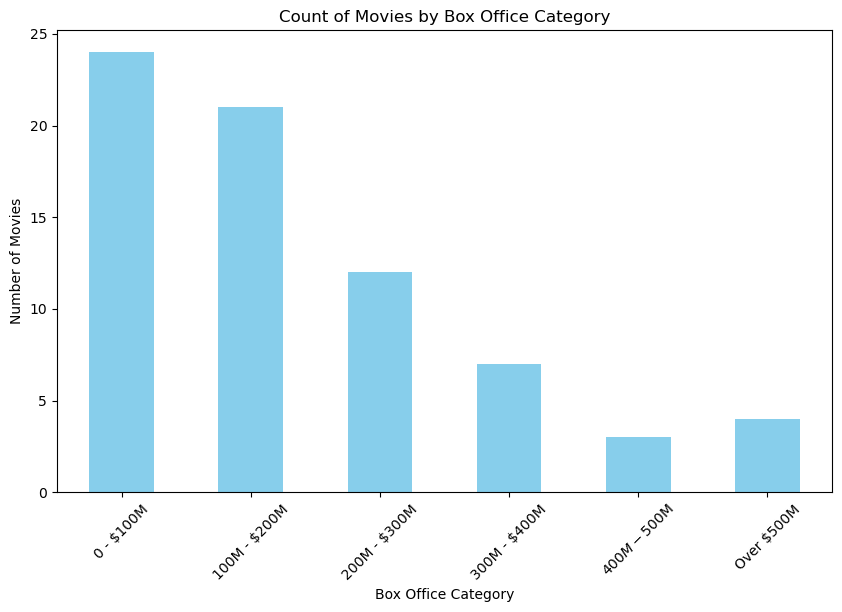

In [140]:
# Bar Graph
grouped.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Titles and labels
plt.title('Count of Movies by Box Office Category')
plt.xlabel('Box Office Category')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_12245/2118342337.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = clean_movie_df2.groupby('Box Office Category')['Oscar Award'].agg(['sum', 'mean'])


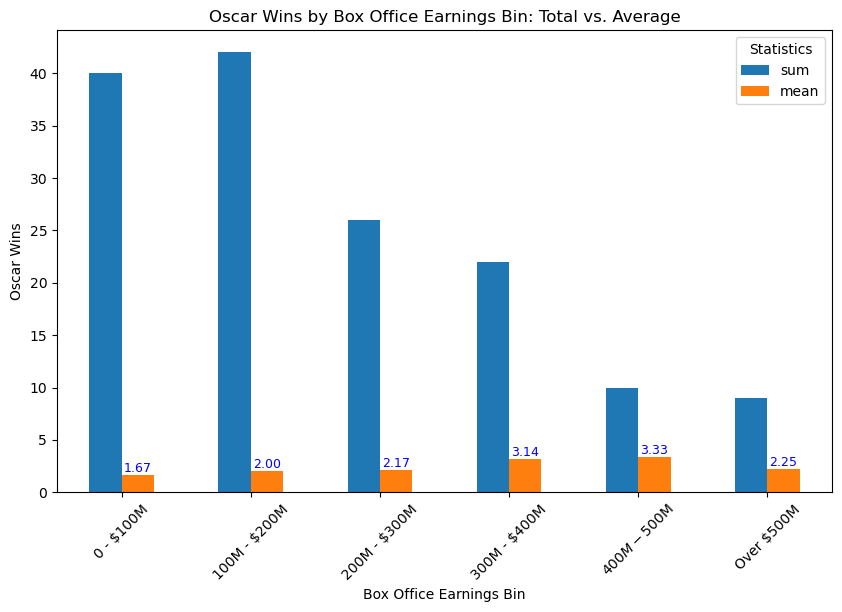

In [141]:
grouped = clean_movie_df2.groupby('Box Office Category')['Oscar Award'].agg(['sum', 'mean'])
fig, ax = plt.subplots(figsize=(10, 6))
grouped.plot(kind='bar', ax=ax)  # This plots both sum and mean as different bars

# Adding labels and title
plt.title('Oscar Wins by Box Office Earnings Bin: Total vs. Average')
plt.xlabel('Box Office Earnings Bin')
plt.ylabel('Oscar Wins')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.legend(title='Statistics')

for i, rect in enumerate(ax.patches[len(ax.patches)//2:]):  # Only the second half of patches which correspond to the 'mean'
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, f'{grouped["mean"].iloc[i]:.2f}', 
            ha='center', va='bottom', rotation=0, color='blue', fontsize=9)
    
# Show the plot
plt.show()

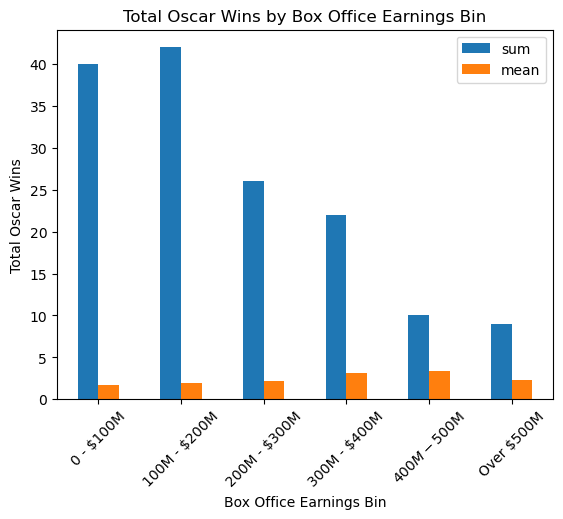

In [142]:
grouped.plot(kind='bar')
plt.title('Total Oscar Wins by Box Office Earnings Bin')
plt.xlabel('Box Office Earnings Bin')
plt.ylabel('Total Oscar Wins')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_12245/1650970685.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df = clean_movie_df2.groupby(['Oscar Nomination', 'Box Office Category']).size().unstack(fill_value=0)


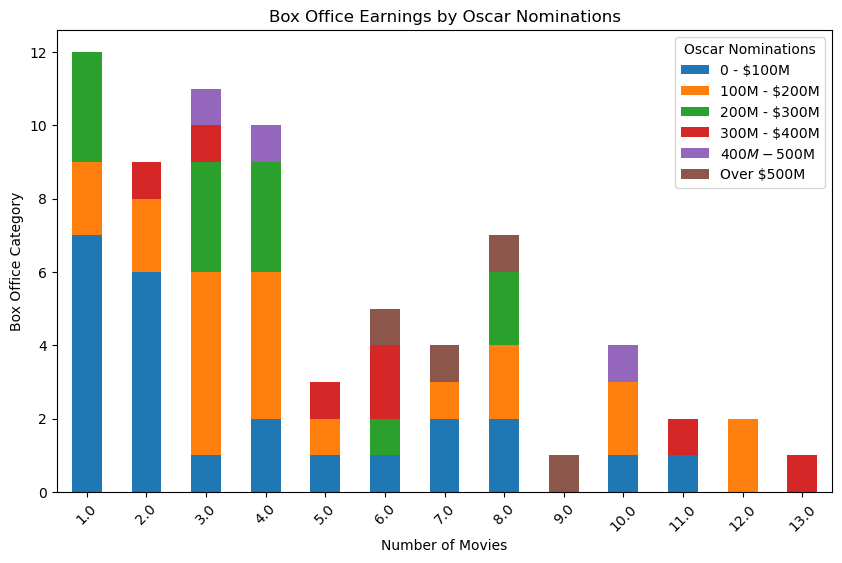

In [143]:
summary_df = clean_movie_df2.groupby(['Oscar Nomination', 'Box Office Category']).size().unstack(fill_value=0)

summary_df.plot(kind='bar', figsize=(10, 6), stacked=True)
plt.title('Box Office Earnings by Oscar Nominations')
plt.xlabel('Number of Movies')
plt.ylabel('Box Office Category')
plt.xticks(rotation=45)  
plt.legend(title='Oscar Nominations')
plt.show()

In [144]:
summary_df.head(15)

Box Office Category,0 - $100M,100M - $200M,200M - $300M,300M - $400M,$400M - $500M,Over $500M
Oscar Nomination,,,,,,
1.0,7,2,3,0,0,0
2.0,6,2,0,1,0,0
3.0,1,5,3,1,1,0
4.0,2,4,3,0,1,0
5.0,1,1,0,1,0,0
6.0,1,0,1,2,0,1
7.0,2,1,0,0,0,1
8.0,2,2,2,0,0,1
9.0,0,0,0,0,0,1


In [145]:
awards_wins_x = clean_movie_df2['Oscar Nomination']
box_office_y = clean_movie_df2['Box Office']

print('NaNs in Oscar Nomination:', awards_wins_x.isna().sum())
print('NaNs in Box Office:', box_office_y.isna().sum())
print('NaNs in Rotten Tomatoes Rating:', awards_wins_x.isna().sum())
print('Infs in Oscar Nomination:', np.isinf(awards_wins_x).sum())
print('Infs in Box Office:', np.isinf(box_office_y).sum())
print('Infs in Rotten Tomatoes Rating:', awards_wins_x.isna().sum())

NaNs in Oscar Nomination: 0
NaNs in Box Office: 0
NaNs in Rotten Tomatoes Rating: 0
Infs in Oscar Nomination: 0
Infs in Box Office: 0
Infs in Rotten Tomatoes Rating: 0


The r-value is: PearsonRResult(statistic=0.3154616065336829, pvalue=0.007367887727307038)


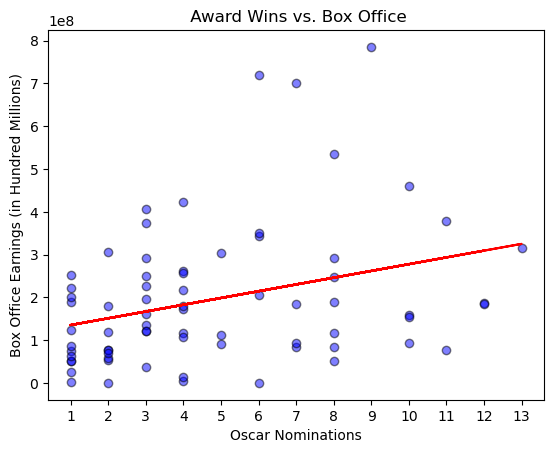

In [146]:
# Define my x and y axis
awards_wins_x = clean_movie_df2['Oscar Nomination']
box_office_y = clean_movie_df2['Box Office']

# Correlation
correlation = st.pearsonr(awards_wins_x, box_office_y) 

#Linear Regression
(slope, intercept, r_value, p_value, std_err) = linregress(awards_wins_x, box_office_y)
regress_values = awards_wins_x * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"

plt.scatter(awards_wins_x, box_office_y, 
            marker='o', 
            facecolors='blue', 
            edgecolors='black',
            alpha=0.5)

plt.plot(awards_wins_x, regress_values, "r-")  # Corrected to use regress_values
#plt.annotate(line_eq, xy=(0.05, 0.95), xycoords='axes fraction',
#             fontsize=12, color="red", verticalalignment='top')

ax = plt.gca() 
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))

# Title, labels, and aesthetics
plt.title(' Award Wins vs. Box Office')
plt.xlabel('Oscar Nominations')
plt.ylabel('Box Office Earnings (in Hundred Millions)')
plt.grid(False)

print(f'The r-value is: {correlation}')

In [147]:
clean_movie_df2.to_csv('movies_awards_analysis.csv', index=False) 